In [11]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical, np_utils
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger

# Audio
import librosa
import librosa.display
import wave
import IPython.display as ipd

# Plot
import matplotlib.pyplot as plt

# Utility
import os
from glob import glob
import numpy as np
from tqdm import tqdm
import itertools
import numpy as np
from scipy.io import wavfile
import fnmatch

In [3]:
set_a = pd.read_csv(r'\Users\mike1\Documents\Thinkful\set_a.csv')
set_a_timing = pd.read_csv(r'\Users\mike1\Documents\Thinkful\set_a_timing.csv')
set_b = pd.read_csv(r'\Users\mike1\Documents\Thinkful\set_b.csv')

In [4]:
print(set_a.head())
print(set_a_timing.head())
print(set_b.head())

  dataset                             fname     label  sublabel
0       a  set_a/artifact__201012172012.wav  artifact       NaN
1       a  set_a/artifact__201105040918.wav  artifact       NaN
2       a  set_a/artifact__201105041959.wav  artifact       NaN
3       a  set_a/artifact__201105051017.wav  artifact       NaN
4       a  set_a/artifact__201105060108.wav  artifact       NaN
                            fname  cycle sound  location
0  set_a/normal__201102081321.wav      1    S1     10021
1  set_a/normal__201102081321.wav      1    S2     20759
2  set_a/normal__201102081321.wav      2    S1     35075
3  set_a/normal__201102081321.wav      2    S2     47244
4  set_a/normal__201102081321.wav      3    S1     62992
  dataset                                              fname       label  \
0       b  set_b/Btraining_extrastole_127_1306764300147_C...  extrastole   
1       b  set_b/Btraining_extrastole_128_1306344005749_A...  extrastole   
2       b  set_b/Btraining_extrastole_130_1306

In [5]:
set_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
dataset     176 non-null object
fname       176 non-null object
label       124 non-null object
sublabel    0 non-null float64
dtypes: float64(1), object(3)
memory usage: 5.6+ KB


Labels percentage
 artifact    0.227273
murmur      0.193182
normal      0.176136
extrahls    0.107955
Name: label, dtype: float64


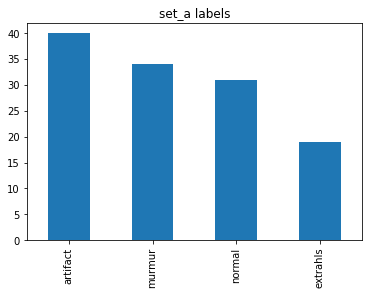

In [6]:
set_a['label'].value_counts().plot.bar(title = "set_a labels")
print("Labels percentage\n", set_a['label'].value_counts()/len(set_a))

In [7]:
set_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 4 columns):
dataset     656 non-null object
fname       656 non-null object
label       461 non-null object
sublabel    149 non-null object
dtypes: object(4)
memory usage: 20.6+ KB


Labels percentage
 normal        0.487805
murmur        0.144817
extrastole    0.070122
Name: label, dtype: float64


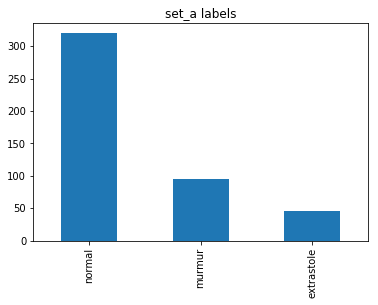

In [8]:
set_b['label'].value_counts().plot.bar(title = "set_a labels")
print("Labels percentage\n", set_b['label'].value_counts()/len(set_b))

Labels percentage
 noisynormal    0.182927
noisymurmur    0.044207
Name: sublabel, dtype: float64


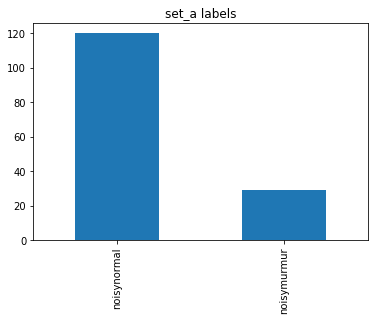

In [9]:
set_b['sublabel'].value_counts().plot.bar(title = "set_a labels")
print("Labels percentage\n", set_b['sublabel'].value_counts()/len(set_b))

In [12]:
data_dir = '.\Documents\set_a'
audio_files = glob(data_dir + '\*.wav')
len(audio_files)

832

In [13]:
y, sr = librosa.load(audio_files[1])  #default sampling rate is 22 HZ
dur = librosa.get_duration(y)
print ("duration:", dur)
print(y.shape, sr)

duration: 9.0
(198450,) 22050


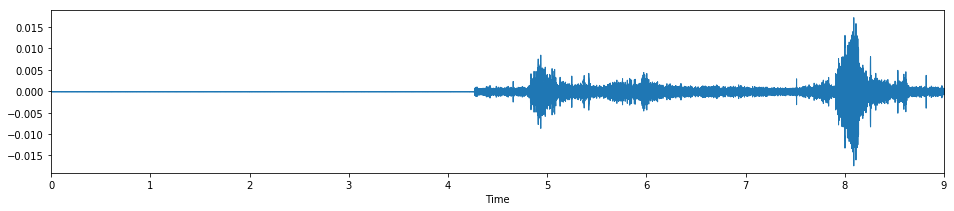

In [14]:
# librosa plot
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y, sr=sr)

In [15]:
normal_heart = "./Documents/set_a/normal__201106111136.wav"

In [16]:
ipd.Audio(normal_heart) 

In [17]:
wav = wave.open(normal_heart)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  218903
Duration =  4.963786848072562


In [18]:
# Load use scipy
rate, data = wavfile.read(normal_heart)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


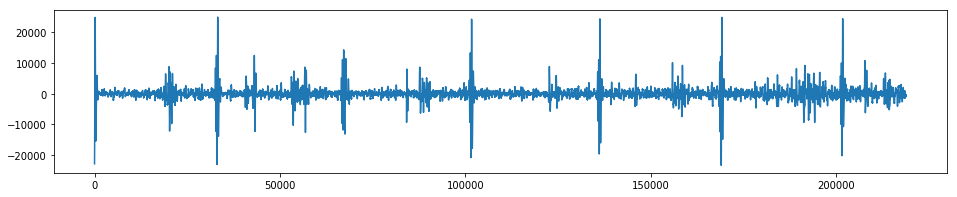

In [19]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', );

In [20]:
data_dir = "./Documents/Thinkful"
set_a=pd.read_csv(data_dir + "/set_a.csv")
set_a.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [21]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data without padding highest quality audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0) 
        except Exception as e:
            print("Error encountered while parsing file: ", file)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

# get audio data with a fix padding may also chop off some file
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [22]:
# Map label text to integer
CLASSES = ['artifact','murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


In [23]:
# parent folder of sound files
INPUT_DIR="./Documents"
# 16 KHz
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION=12  

#Load dataset a and b
A_folder=INPUT_DIR+'/set_a/'
# set-a
A_artifact_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder,file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder,file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

print ("loaded dataset-a")

# load dataset-b, keep them separate for testing purpose 
B_folder=INPUT_DIR+'/set_a/'
# set-b
B_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_files]

B_extrastole_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [1 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")

load file  ./Documents/set_a/artifact__201012172012.wav
fixing audio lenght : artifact__201012172012.wav
load file  ./Documents/set_a/artifact__201105040918.wav
fixing audio lenght : artifact__201105040918.wav
load file  ./Documents/set_a/artifact__201105041959.wav
fixing audio lenght : artifact__201105041959.wav
load file  ./Documents/set_a/artifact__201105051017.wav
fixing audio lenght : artifact__201105051017.wav
load file  ./Documents/set_a/artifact__201105060108.wav
fixing audio lenght : artifact__201105060108.wav
load file  ./Documents/set_a/artifact__201105061143.wav
fixing audio lenght : artifact__201105061143.wav
load file  ./Documents/set_a/artifact__201105190800.wav
fixing audio lenght : artifact__201105190800.wav
load file  ./Documents/set_a/artifact__201105280851.wav
fixing audio lenght : artifact__201105280851.wav
load file  ./Documents/set_a/artifact__201106010559.wav
fixing audio lenght : artifact__201106010559.wav
load file  ./Documents/set_a/artifact__201106010602.wav

In [24]:
#combine set-a and set-b 
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds, 
                         B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  1000 247


In [25]:
seed = 1000
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(keras.utils.to_categorical(test_y, len(CLASSES)))

C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [28]:
x_train.shape

(810, 40, 1)

### Models

In [28]:
print('First LSTM RNN model')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()

# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=32

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback) 

print ("training finised!")

# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(x_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

score = model.evaluate(test_x, test_y, verbose=0) 
print ("model unlabeled data score   : ", round(score[1]*100), "%")

First LSTM RNN model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 40, 64)            16896     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 29,411
Trainable params: 29,411
Non-trainable params: 0
_________________________________________________________________
training started..... please wait.

Epoch 00001: loss improved from inf to 0.84198, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 0.84198 to 0.70737, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 0.70737 to 0.67936, saving model to ./best_model_trained.hdf5

Epoch 00004: loss improved from 0.67936 to

In [29]:
print('Second LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.1, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.1, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()

best_model_file="./best_model_trained.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=200
MAX_BATCH=32

callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]
# training
history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback) 

# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(x_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

score = model.evaluate(test_x, test_y, verbose=0) 
print ("model unlabeled data score   : ", round(score[1]*100), "%")

Second LSTM RNN model ...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 40, 64)            16896     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 29,411
Trainable params: 29,411
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: loss improved from inf to 0.82757, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 0.82757 to 0.72808, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 0.72808 to 0.68476, saving model to ./best_model_trained.hdf5

Epoch 00004: loss improved from 0.68476 to 0.67590, saving model to ./be

In [30]:
print('Third LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()

best_model_file="./best_model_trained.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=64

callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]
# training
history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback) 

# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(x_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

score = model.evaluate(test_x, test_y, verbose=0) 
print ("model unlabeled data score   : ", round(score[1]*100), "%")

Third LSTM RNN model ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 40, 128)           66560     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 87,267
Trainable params: 87,267
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: loss improved from inf to 0.86119, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 0.86119 to 0.70241, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 0.70241 to 0.68239, saving model to ./best_model_trained.hdf5

Epoch 00004: loss improved from 0.68239 to 0.67908, saving model to ./bes

In [31]:
print('Fourth LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=128, dropout=0.1, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=128, dropout=0.1, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()

best_model_file="./best_model_trained.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=64

callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]
# training
history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback) 

# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(x_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

score = model.evaluate(test_x, test_y, verbose=0) 
print ("model unlabeled data score   : ", round(score[1]*100), "%")

Fourth LSTM RNN model ...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 40, 128)           66560     
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 198,531
Trainable params: 198,531
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: loss improved from inf to 0.76516, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 0.76516 to 0.65829, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 0.65829 to 0.63829, saving model to ./best_model_trained.hdf5

Epoch 00004: loss did not improve from 0.63829

Epoch 00005: loss impr

In [32]:
print('Final LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=64, dropout=0.1, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()

best_model_file="./best_model_trained.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=32

callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]
# training
history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback) 

# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(x_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

score = model.evaluate(test_x, test_y, verbose=0) 
print ("model unlabeled data score   : ", round(score[1]*100), "%")

Final LSTM RNN model ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 40, 128)           66560     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 116,163
Trainable params: 116,163
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: loss improved from inf to 0.77098, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 0.77098 to 0.69256, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 0.69256 to 0.66814, saving model to ./best_model_trained.hdf5

Epoch 00004: loss improved from 0.66814 to 0.65130, saving model to ./b